In [1]:
%load_ext autoreload
%autoreload 2
import comethylation, get_data, analysis, utils

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr

In [3]:
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")

### Read in data

In [4]:
out_dir = "./output_090622"
dependency_f_dir = "./dependency_files"
data_dir = "./data"

In [5]:
illumina_cpg_locs_df, all_mut_df, all_methyl_df, all_methyl_df_t, all_meta_df, dataset_names_list = get_data.main(os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"),
                                                                                                                  out_dir,
                                                                                                                  os.path.join(data_dir, "processed_methylation"),
                                                                                                                  os.path.join(data_dir, "PANCAN_mut.tsv.gz"),
                                                                                                                  os.path.join(data_dir, "PANCAN_meta.tsv"))


Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


In [6]:
# read in other already computed files

# from running analysis.main()
ct_mut_in_measured_cpg_w_methyl_df = pd.read_parquet(os.path.join(dependency_f_dir, "ct_mut_in_measured_cpg_w_methyl_df.parquet"))

# correlations between all CpGs on chrom1
chrom_one_corr = pd.read_parquet(os.path.join(dependency_f_dir,"all_corrs_chrom1.parquet"))
# association of all CpGs on chrom1 with age
ewas_df = pd.read_parquet(os.path.join(dependency_f_dir, "all_chr1_EWAS_results_PANCAN.parquet"))

In [7]:
# calculate distances between all CpGs on chrom 1
chrom_one_distances = utils.get_distances_one_chrom('1',
                            illumina_cpg_locs_df.loc[illumina_cpg_locs_df['#id'].isin(all_methyl_df_t.columns)])

## Do mutation analyses

/cellar/users/zkoch/methylation_and_mutation/analysis.py:64: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write("Effect size: {}\n".format( ct_mutation_in_measured_cpg_df.mean()))


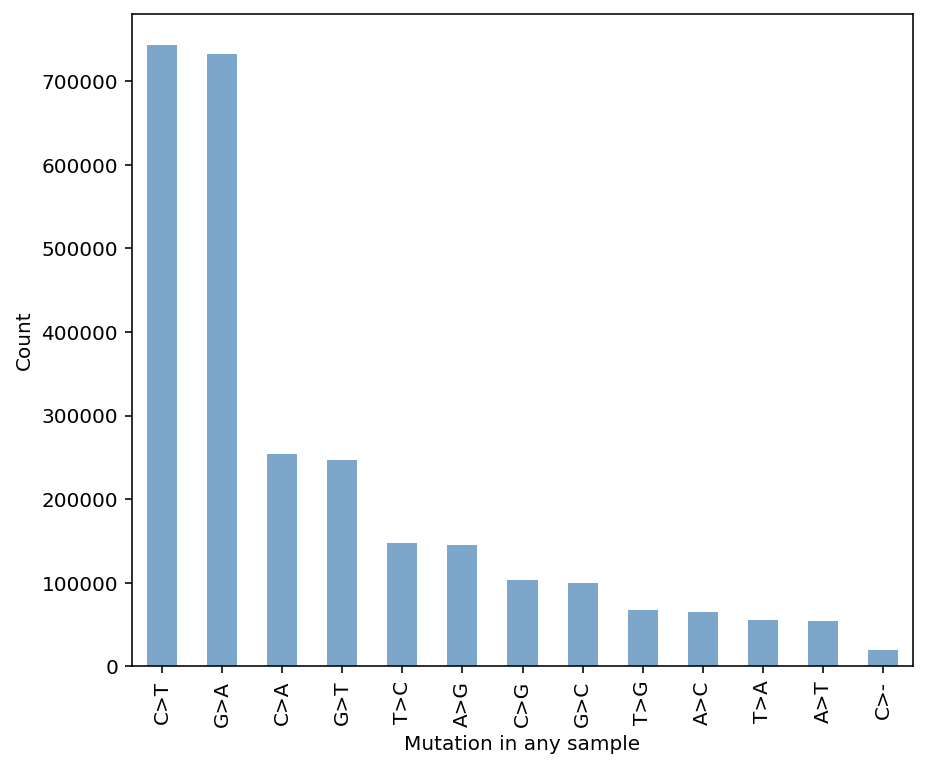

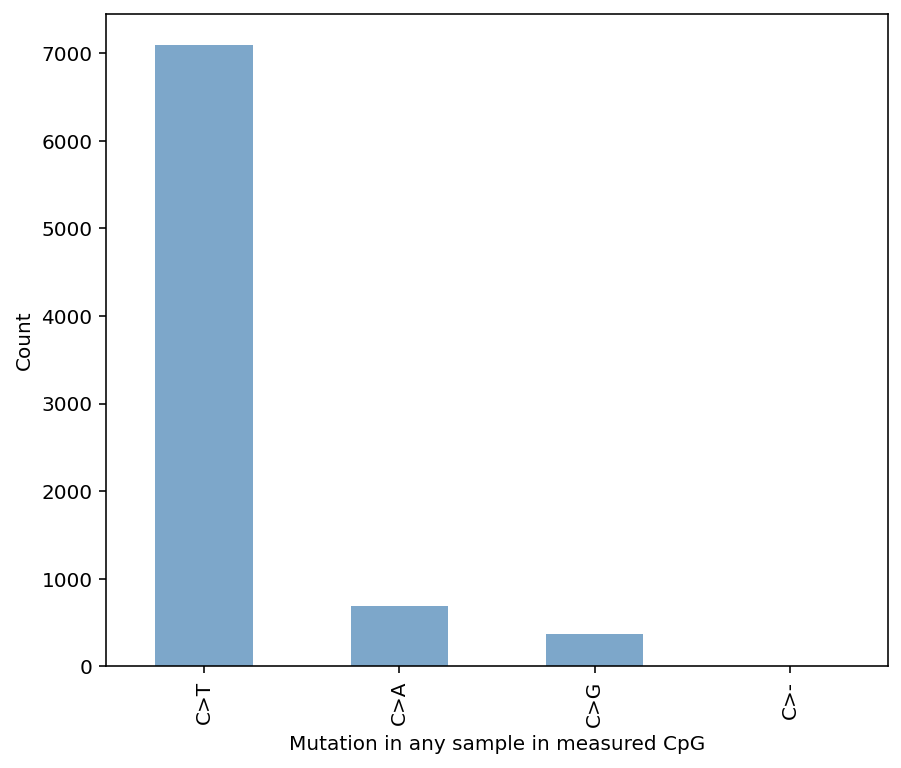

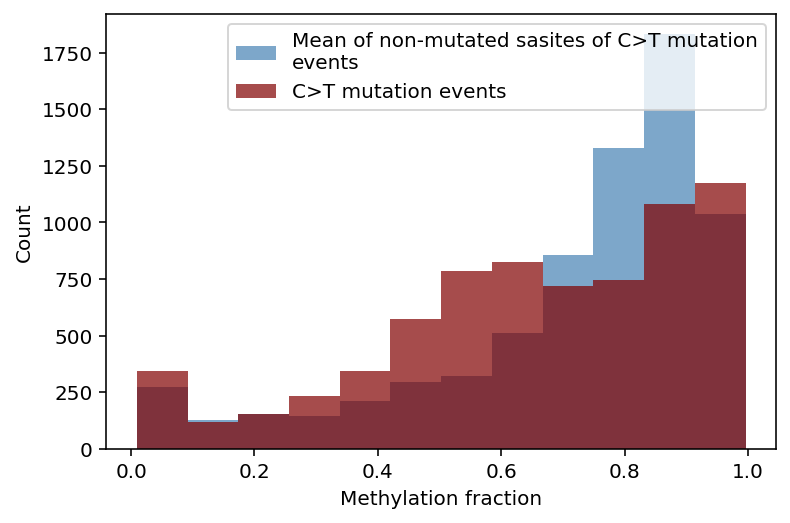

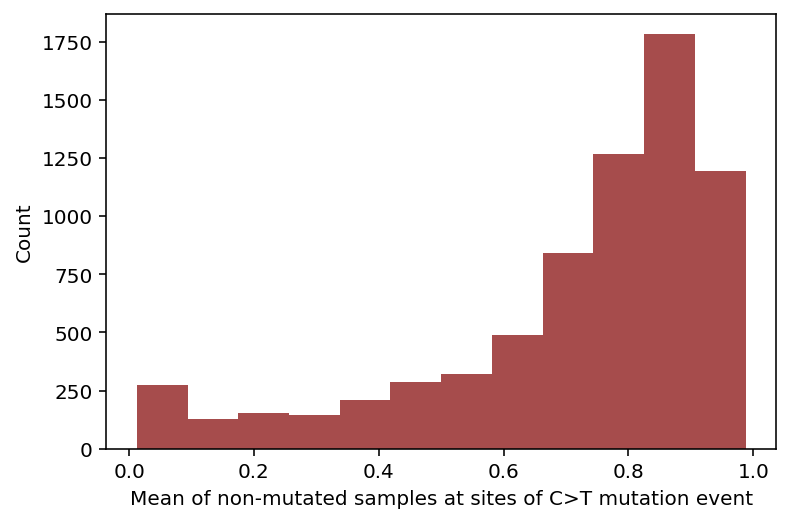

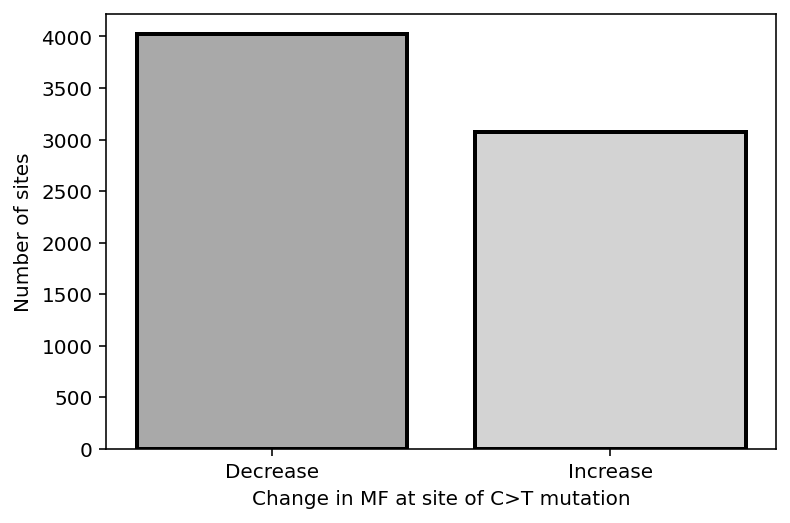

In [20]:
mut_in_measured_cpg_df, ct_mut_in_measured_cpg_df, ct_mut_in_measured_cpg_w_methyl_df = analysis.main(illumina_cpg_locs_df, out_dir, all_mut_df, all_methyl_df_t, all_meta_df, dataset_names_list) 

In [18]:
# save ct_mut_in_measured_cpg_w_methyl_df
ct_mut_in_measured_cpg_w_methyl_df.to_parquet(os.path.join(dependency_f_dir, "ct_mut_in_measured_cpg_w_methyl_df.parquet"))

In [6]:
# read in 
ct_mut_in_measured_cpg_w_methyl_df = pd.read_parquet(os.path.join(dependency_f_dir, "ct_mut_in_measured_cpg_w_methyl_df.parquet"))

## Do comethylation analysis

### comethylation without absolute value

In [13]:
# add ages to ct_mut_in_measured_cpg_w_methyl_df
ct_mut_in_measured_cpg_w_methyl_age_df, all_methyl_age_df_t = comethylation.add_ages_to_methylation(ct_mut_in_measured_cpg_w_methyl_df, all_meta_df, all_methyl_df_t)

In [14]:
# subset chrom_one_corr to only sites that are in all_methyl_df_t
chrom_one_corr = chrom_one_corr[(chrom_one_corr.columns) & (all_methyl_age_df_t.columns)]
chrom_one_corr = chrom_one_corr.loc[chrom_one_corr.columns]

/tmp/ipykernel_251477/2271471010.py:2: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  chrom_one_corr = chrom_one_corr[(chrom_one_corr.columns) & (all_methyl_age_df_t.columns)]


In [17]:
# get num_mut_sites sites with largeset MF differences that are on chrom 1 to use as sites in co-methylation analysis
num_mut_sites = 100
most_negative_mut_diffs = ct_mut_in_measured_cpg_w_methyl_age_df[ct_mut_in_measured_cpg_w_methyl_age_df['#id'].isin(chrom_one_corr.columns)].sort_values(by='difference').iloc[:num_mut_sites]

In [18]:
# set linkage type and get the mut_linkage_df based on this type and the 
linkage_type = 'methylation_corr'
if linkage_type == 'methylation_corr':
    mut_linkage_df = chrom_one_corr[most_negative_mut_diffs['#id']]    
elif linkage_type == 'distance':
    mut_linkage_df = chrom_one_distances[most_negative_mut_diffs['#id']] 

In [231]:
# Run co-methylation, takes a while
# calculate mutation impact varying percentile of linked CpG sites
result_dfs = comethylation.mutation_eff_varying_linkage(mut_linkage_df,
                                linkage_type,
                                ct_mut_in_measured_cpg_w_methyl_age_df,
                                all_methyl_age_df_t,
                                illumina_cpg_locs_df,
                                num_linked_sites = 200,
                                age_bin_size = 10)

1.0
0.9
0.8
0.7000000000000001
0.6000000000000001
0.5
0.4
0.30000000000000004
0.2
0.1
0.0


In [232]:
# write out result_dfs
utils.write_out_result_dfs(out_dir, 'comethyl_200_sites_varying_corr_perc_chr1', result_dfs)

In [9]:
# read in result_dfs
result_dfs = utils.read_in_result_dfs(os.path.join(out_dir, 'comethyl_200_sites_varying_corr_perc_chr1'))

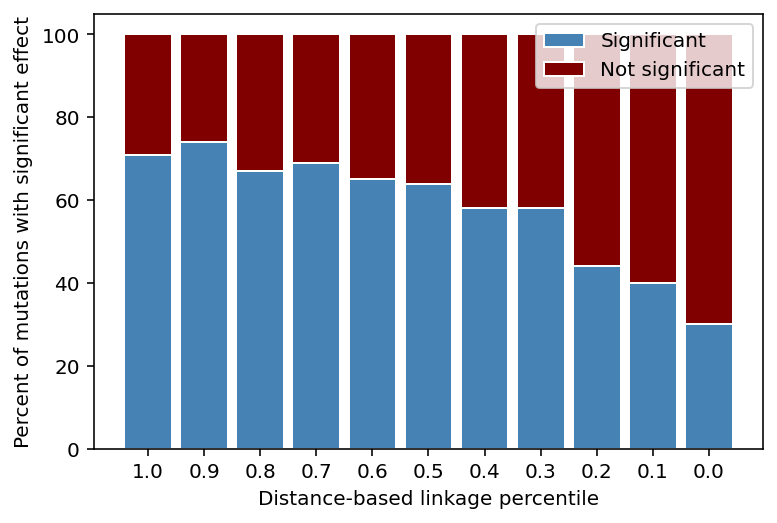

In [10]:
comethylation.plot_sig_bars(result_dfs)

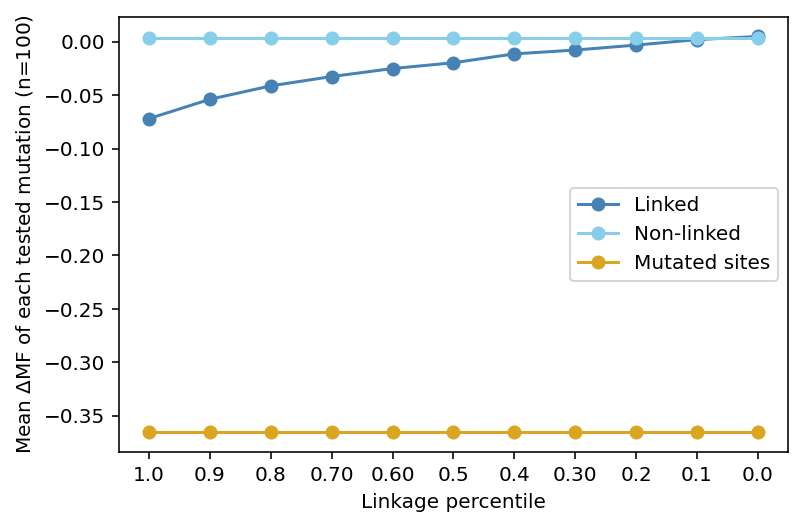

In [19]:
#comethylation.plot_eff_line(result_dfs, ct_mut_in_measured_cpg_w_methyl_age_df, max_diff_corr_df, sig_only=True)
comethylation.plot_eff_line(result_dfs, ct_mut_in_measured_cpg_w_methyl_age_df, mut_linkage_df, sig_only=False)

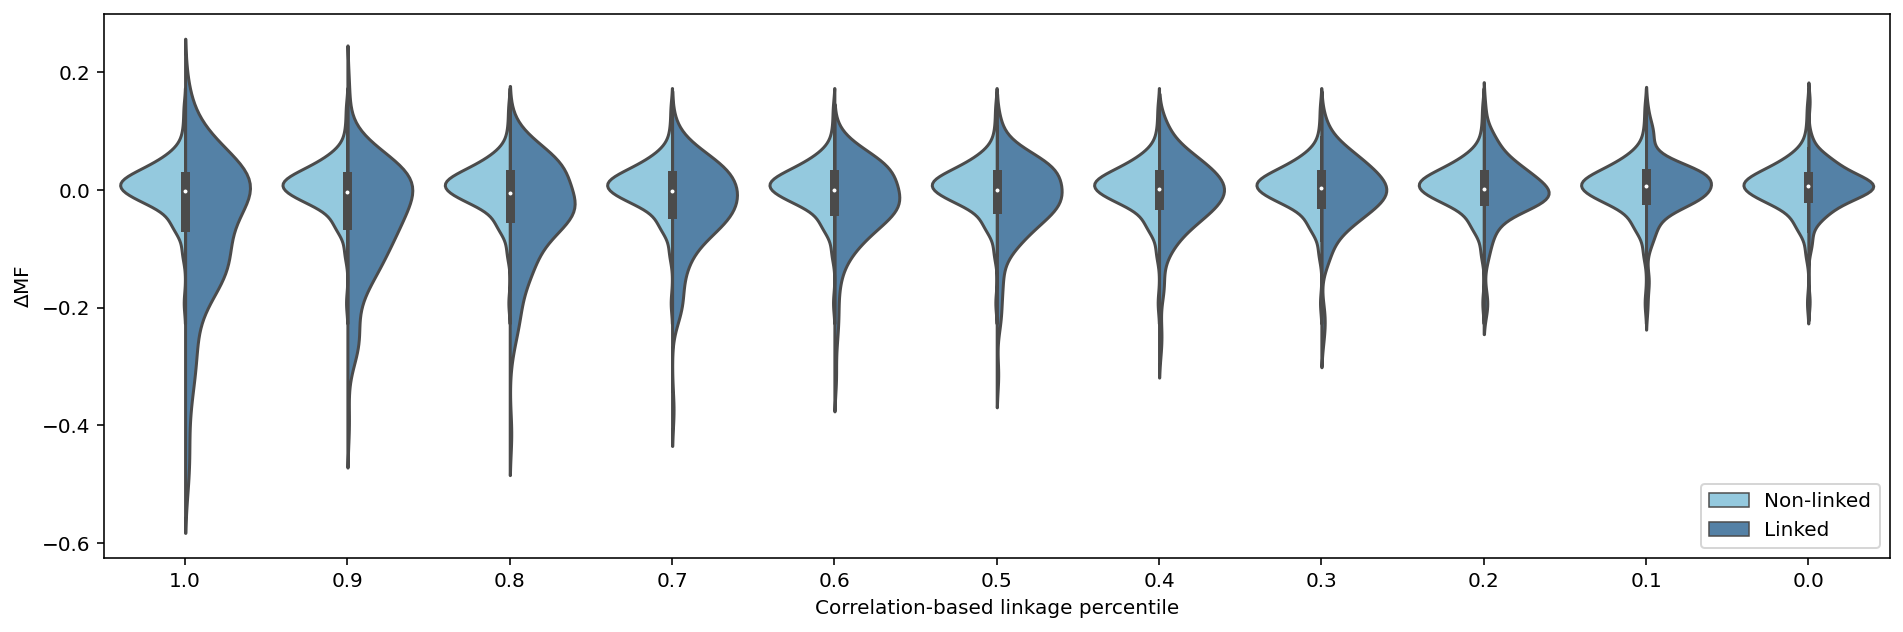

In [21]:
# this is all sites, not just sig
comethylation.plot_eff_violin(result_dfs)

## Miscellaneous code to save

### Get all correlations chrom 1

In [13]:
chr_methyl_df = all_methyl_df.loc[all_methyl_df.index.isin(illumina_cpg_locs_df[illumina_cpg_locs_df.chr == "1"]['#id'].to_list())]

In [15]:
chrom_one_corr = chr_methyl_df.T.corr()
chrom_one_corr.to_parquet(os.path.join(dependency_f_dir,"all_corrs_chrom1_PANCAN.parquet"))

In [11]:
# read back in 
chrom_one_corr = pd.read_parquet(os.path.join(dependency_f_dir,"all_corrs_chrom1.parquet"))

### EWAS chr1

In [7]:
# only keep sites on chr 1
chr_methyl_df = all_methyl_df.loc[all_methyl_df.index.isin(illumina_cpg_locs_df[illumina_cpg_locs_df.chr == "1"]['#id'].to_list())]
# only keep ages that match to columns of chr_methyl_df
meta_df = all_meta_df.loc[all_meta_df.index.isin(chr_methyl_df.columns)]
# only keep columns that have ages
chr_methyl_df = chr_methyl_df[chr_methyl_df.columns[chr_methyl_df.columns.isin(meta_df.index)]]
# put samples in same order as methylation
meta_df = meta_df.loc[chr_methyl_df.columns]

In [8]:
# do EWAS calculation
ewas_df = utils.EWAS(X = chr_methyl_df, y = meta_df['age_at_index'], out_fn = os.path.join(dependency_f_dir, "all_chr1_EWAS_results_PANCAN.parquet"))
#ewas_df.index = chr_methyl_df.index

In [21]:
# read in if already calculated
ewas_df = pd.read_parquet(os.path.join(dependency_f_dir, "all_chr1_EWAS_results_PANCAN.parquet"))
ewas_df.index = chr_methyl_df.index

In [30]:
ewas_df = ewas_df.sort_values(by = 'pearson_corrs')

## Associating # mutations with % methylation explained, not done

In [29]:
# read in ct_mut_in_measured_cpg_w_methyl_df
ct_mut_in_measured_cpg_w_methyl_df = pd.read_parquet(os.path.join(out_dir, "ct_mut_in_measured_cpg_w_methyl_df.parquet"))
# correlations of each CpG on chr1 with age
ewas_df = pd.read_parquet(os.path.join(out_dir, "all_chr1_EWAS_results.parquet"))
ewas_df.index = chr_methyl_df.index
ewas_df = ewas_df.sort_values(by = 'pearson_corrs')
# co-methylation for all CpGs on chr1
chrom_one_corr = pd.read_parquet(os.path.join(out_dir, "all_corrs_chrom1.parquet"))
# comethylation result dfs
result_dfs = utils.read_in_result_dfs(os.path.join(out_dir, '_100_sites_varying_percentile_chr1'))

### Count mutations nearby 1000 negatively associated CpGs

In [33]:
# we only care about mutations in samples with some methylation (doesn't have to be 
all_mut_w_methyl_df = all_mut_df[all_mut_df['sample'].isin(all_methyl_df.columns.to_list())]
cpg_sample_distance_mut_count_df = comethylation.count_nearby_mutations(ewas_df.iloc[:1000],
                                                                        all_mut_w_methyl_df,
                                                                        illumina_cpg_locs_df,
                                                                        all_methyl_df,
                                                                        10000)

In [ ]:
cpg_sample_distance_mut_count_df.to_parquet(os.path.join(out_dir, "cpg_sample_mut_count_negative_1000.parquet"))

In [32]:
# read in output 
cpg_sample_distance_mut_count_df = pd.read_parquet(os.path.join(out_dir, "cpg_sample_mut_count_negative_1000.parquet"))

### Count LINKED mutations for 1000 negatively associated CpGs

In [ ]:
# instead of counting nearby mutations, count mutations that are in linked CpG sites
cpg_sample_linked_mut_count_df = comethylation.count_linked_mutations(cpgs_to_count_df = ewas_df.iloc[:1000],
                       all_mut_w_methyl_df = all_mut_w_methyl_df,
                       illumina_cpg_locs_df = illumina_cpg_locs_df,
                       all_methyl_df = all_methyl_df, 
                       corr_df = chrom_one_corr, 
                       num=100,
                       percentile_cutoff=.9999)

In [34]:
# read in 1000 sites, 100 linked sites, 100bp each
cpg_sample_ten_linked_mut_count_df = pd.read_parquet(os.path.join(out_dir,"cpg_sample_linked_mut_count_1000_tenLinkedSites_1kbp_df.parquet"))

In [35]:
cpg_sample_thou_linked_mut_count_df = pd.read_parquet(os.path.join(out_dir, "cpg_sample_linked_mut_count_1000_100LinkedSites_100bp_df.parquet"))

### Count mutations all ways for 1000 least age-associated sites

In [40]:
# get least age-associated, lowest 1000 absoluteval
ewas_by_abs = np.abs(ewas_df).sort_values(by = 'pearson_corrs')

In [76]:
# we only care about mutations in samples with some methylation (doesn't have to be 
all_mut_w_methyl_df = all_mut_df[all_mut_df['sample'].isin(all_methyl_df.columns.to_list())]
cpg_sample_distance_mut_count_lowest_df = comethylation.count_nearby_mutations(ewas_by_abs.iloc[:1000],
                                                                        all_mut_w_methyl_df,
                                                                        illumina_cpg_locs_df,
                                                                        all_methyl_df,
                                                                        max_dist=100000)

In [173]:
cpg_sample_distance_mut_count_lowest_df.to_parquet(os.path.join(out_dir, "cpg_sample_mut_count_lowest_1000.parquet"))

In [36]:
cpg_sample_distance_mut_count_lowest_df = pd.read_parquet(os.path.join(out_dir, "cpg_sample_mut_count_lowest_1000.parquet"))

In [37]:
cpg_sample_ten_corr_mut_count_lowest_df = pd.read_parquet(os.path.join(out_dir, "cpg_sample_linked_mut_count_lowest_1000_tenLinkedSites_1kbp_df.parquet"))

In [38]:
cpg_sample_thou_corr_mut_count_lowest_df = pd.read_parquet(os.path.join(out_dir, "cpg_sample_linked_mut_count_leastAssoc_1000_100LinkedSites_100bp_df.parquet"))

### corr(# linked mutations in site i, age) for 1000 sites with strongest negative age association on chr1

In [176]:
# correlation between ages and # linked sites by DISTANCE for 1000cpgs
# keep only samples with ages and ages that have relevant sample
cpg_sample_mut_count_to_corr = cpg_sample_distance_mut_count_df.loc[cpg_sample_distance_mut_count_df.index.isin(all_meta_df.index)]
ages_to_corr = all_meta_df.loc[cpg_sample_mut_count_to_corr.index]['age_at_index']
age_mut_count_corr = cpg_sample_mut_count_to_corr.corrwith(ages_to_corr)

In [179]:
# nonlinked sites distance
cpg_sample_mut_count_lowest_to_corr = cpg_sample_distance_mut_count_lowest_df.loc[cpg_sample_distance_mut_count_lowest_df.index.isin(all_meta_df.index)]
ages_to_corr = all_meta_df.loc[cpg_sample_mut_count_lowest_to_corr.index]['age_at_index']
age_mut_count_lowest_corr = cpg_sample_mut_count_lowest_to_corr.corrwith(ages_to_corr)

In [197]:
# same thing but by 10 linked sites
cpg_sample_ten_mut_count_to_corr_link = cpg_sample_ten_linked_mut_count_df.loc[cpg_sample_ten_linked_mut_count_df.index.isin(all_meta_df.index)]
ages_to_corr_link = all_meta_df.loc[cpg_sample_mut_count_to_corr_link.index]['age_at_index']
age_mut_ten_count_corr_link = cpg_sample_ten_mut_count_to_corr_link.corrwith(ages_to_corr_link)

In [198]:
# 10 linked sites nonlinked
cpg_sample_ten_mut_count_lowest_to_corr_link = cpg_sample_ten_corr_mut_count_lowest_df.loc[cpg_sample_ten_corr_mut_count_lowest_df.index.isin(all_meta_df.index)]
ages_to_corr_link = all_meta_df.loc[cpg_sample_ten_mut_count_lowest_to_corr_link.index]['age_at_index']
age_mut_ten_count_lowest_corr_link = cpg_sample_ten_mut_count_lowest_to_corr_link.corrwith(ages_to_corr_link)

In [299]:
# 100 linked sites linked
cpg_sample_thou_mut_count_to_corr_link = cpg_sample_thou_linked_mut_count_df.loc[cpg_sample_thou_linked_mut_count_df.index.isin(all_meta_df.index)]
ages_to_corr_link = all_meta_df.loc[cpg_sample_thou_mut_count_to_corr_link.index]['age_at_index']
age_mut_thou_count_corr_link = cpg_sample_thou_mut_count_to_corr_link.corrwith(ages_to_corr_link)

In [301]:
# 10 linked sites nonlinked
cpg_sample_thou_mut_count_lowest_to_corr_link = cpg_sample_thou_corr_mut_count_lowest_df.loc[cpg_sample_thou_corr_mut_count_lowest_df.index.isin(all_meta_df.index)]
ages_to_corr_link = all_meta_df.loc[cpg_sample_thou_mut_count_lowest_to_corr_link.index]['age_at_index']
age_mut_thou_count_lowest_corr_link = cpg_sample_thou_mut_count_lowest_to_corr_link.corrwith(ages_to_corr_link)

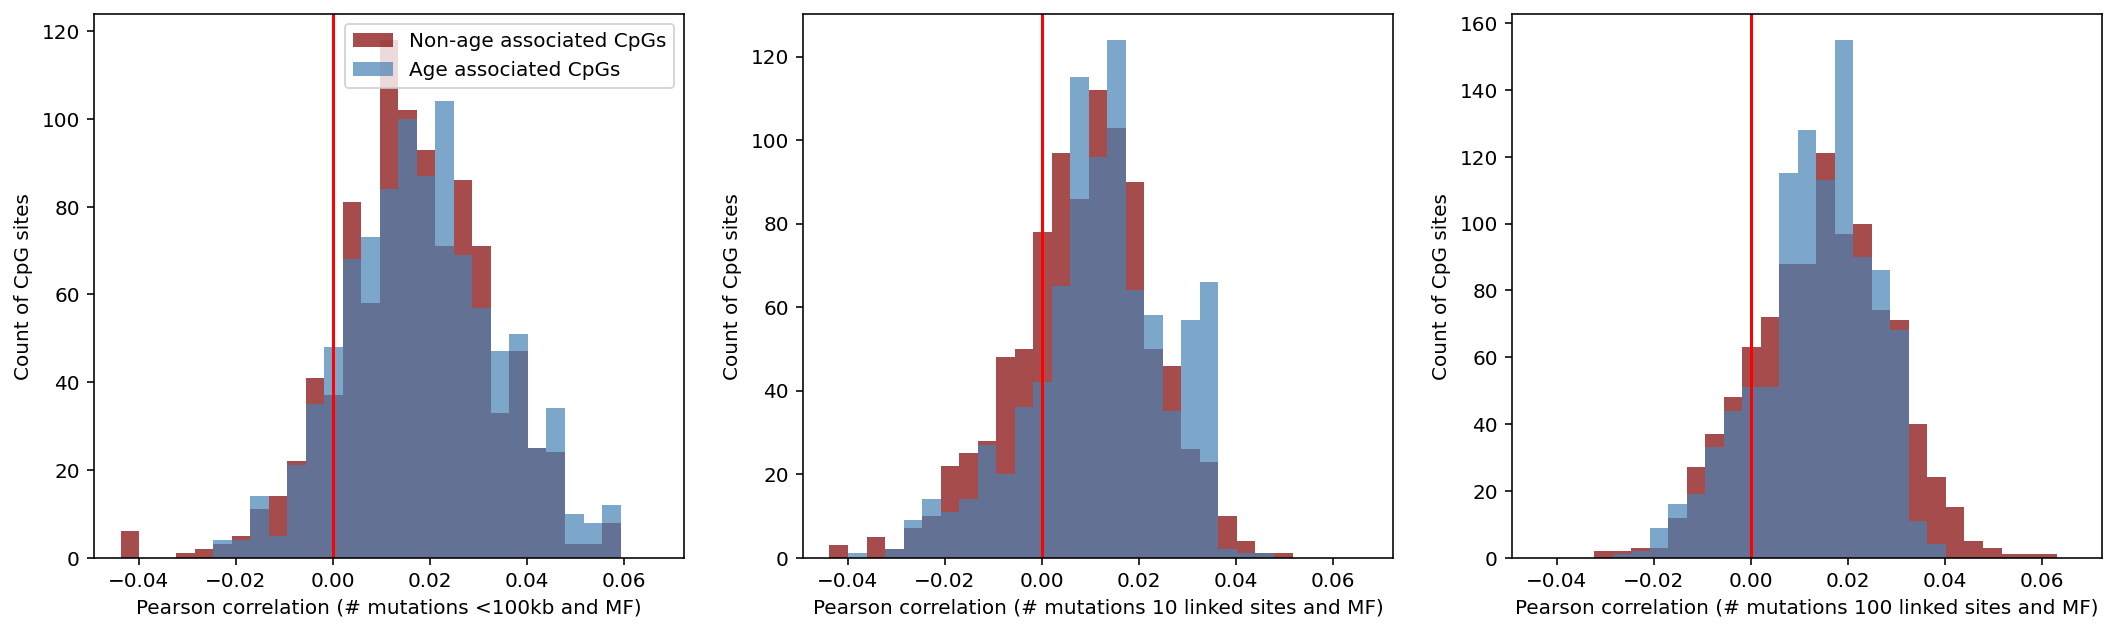

In [307]:
fig, axes = plt.subplots(1,3, figsize=(18,5), sharex='all')

minn = min(age_mut_count_corr.min(),age_mut_count_lowest_corr.min())
maxx =max(age_mut_count_corr.max(),age_mut_count_lowest_corr.max())
age_mut_count_lowest_corr.plot.hist(bins=np.arange(minn, maxx, (maxx - minn)/30) , ax=axes[0],color='maroon',alpha=0.7,label="Non-age associated CpGs" )
age_mut_count_corr.plot.hist(bins=np.arange(minn, maxx, (maxx - minn)/30), ax=axes[0], color='steelblue',alpha=0.7,label="Age associated CpGs")
axes[0].set_xlabel("Pearson correlation (# mutations <100kb and MF)")
axes[0].set_ylabel("Count of CpG sites")
axes[0].axvline(x=0, c='r')
axes[0].legend()

age_mut_ten_count_lowest_corr_link.plot.hist(bins=np.arange(minn, maxx, (maxx - minn)/30), ax=axes[1], color='maroon',alpha=0.7)
age_mut_ten_count_corr_link.plot.hist(bins=np.arange(minn, maxx, (maxx - minn)/30), ax=axes[1], color='steelblue',alpha=0.7)
axes[1].set_xlabel("Pearson correlation (# mutations 10 linked sites and MF)")
axes[1].set_ylabel("Count of CpG sites")
axes[1].axvline(x=0, c='r')

age_mut_thou_count_lowest_corr_link.plot.hist(bins=np.arange(minn, maxx, (maxx - minn)/30), ax=axes[2], color='maroon',alpha=0.7)
age_mut_thou_count_corr_link.plot.hist(bins=np.arange(minn, maxx, (maxx - minn)/30), ax=axes[2], color='steelblue',alpha=0.7)
axes[2].set_xlabel("Pearson correlation (# mutations 100 linked sites and MF)")
axes[2].set_ylabel("Count of CpG sites")
axes[2].axvline(x=0, c='r')

### corr(#linked mutations,MF)

In [41]:
# subset to CpGs most negatively asspociated with age
meth_corr = cpg_sample_distance_mut_count_df.corrwith(all_methyl_df_t[ewas_df.iloc[:1000].index])
meth_lowest_corr = cpg_sample_distance_mut_count_lowest_df.corrwith(all_methyl_df_t[ewas_by_abs.iloc[:1000].index])

meth_corr_ten_link = cpg_sample_ten_linked_mut_count_df.corrwith(all_methyl_df_t[ewas_df.iloc[:1000].index])
meth_corr_ten_lowest_link = cpg_sample_ten_corr_mut_count_lowest_df.corrwith(all_methyl_df_t[ewas_by_abs.iloc[:1000].index])

meth_corr_thou_link = cpg_sample_thou_linked_mut_count_df.corrwith(all_methyl_df_t[ewas_df.iloc[:1000].index])
meth_corr_thou_lowest_link = cpg_sample_thou_corr_mut_count_lowest_df.corrwith(all_methyl_df_t[ewas_by_abs.iloc[:1000].index])


In [ ]:
fig, axes = plt.subplots(1,3, figsize=(18,5), sharex='all')

minn = min(meth_corr.min(),meth_lowest_corr.min())
maxx =max(meth_corr.max(),meth_lowest_corr.max())
meth_corr.plot.hist(bins=np.arange(minn, maxx, (maxx - minn)/30) , ax=axes[0],color='maroon',alpha=0.7,label="Age associated CpGs")
meth_lowest_corr.plot.hist(bins=np.arange(minn, maxx, (maxx - minn)/30), ax=axes[0], color='steelblue',alpha=0.7, label="Non-age associated")
axes[0].set_xlabel("Pearson correlation (# mutations <100kb and MF)")
axes[0].set_ylabel("Count of CpG sites")
axes[0].axvline(x=0, c='r')
axes[0].legend()

meth_corr_link.plot.hist(bins=np.arange(minn, maxx, (maxx - minn)/30), ax=axes[1],color='maroon',alpha=0.7,label="Age associated")
meth_corr_ten_lowest_link.plot.hist(bins=np.arange(minn, maxx, (maxx - minn)/30), ax=axes[1],color='steelblue',alpha=0.7,label="Age associated")
axes[1].set_xlabel("Pearson correlation (# mutations 10 linked sites and MF)")
axes[1].set_ylabel("Count of CpG sites")
axes[1].axvline(x=0, c='r')

meth_corr_thou_link.plot.hist(bins=np.arange(minn, maxx, (maxx - minn)/30), ax=axes[2], color='maroon', alpha=0.7,label="Age associated")
meth_corr_thou_lowest_link.plot.hist(bins=np.arange(minn, maxx, (maxx - minn)/30), ax=axes[2],color='steelblue', alpha=0.7,label="Age associated")
axes[2].set_xlabel("Pearson correlation (# mutations 100 linked sites and MF)")
axes[2].set_ylabel("Count of CpG sites")
axes[2].axvline(x=0, c='r')

"""
- This shows that the CpG sites which lose the most methylation with age, on average, have methylations more correlated with the # of linked 
mutations, than sites whose methylation is not correlated with age.
    - correlation with

"""

## Distance-MF correlation plots

In [ ]:
fig, axes = plt.subplots()
this_dist_corr_df = dist_corr_df
this_dist_corr_df['distance'] = np.log(this_dist_corr_df['distance'])
bin_edges = []
for i in range(6):
    step = (dist_corr_df['distance'].max() - dist_corr_df['distance'].min())/5
    bin_edges.append(dist_corr_df['distance'].min() + (step * i))
print(bin_edges)

boxes = [dist_corr_df[(dist_corr_df['distance'] < bin_edges[i+1] ) & (dist_corr_df['distance'] >= bin_edges[i])]['corr'] for i in range(len(bin_edges)-1)]


bp = axes.boxplot(boxes, flierprops=dict(markersize=.1), showfliers=False, labels=["{} - {}".format(round(bin_edges[i],1), round(bin_edges[i+1],1) ) for i in range(len(bin_edges)-1)], patch_artist=True, boxprops=dict(facecolor="maroon", alpha=0.7, ))
# change color of median
for median in bp['medians']: 
    median.set(color ='black', 
               linewidth = 1)
axes.set_xlabel("log-distance bp")
axes.set_ylabel("CpG pair Pearson r")

dist_corr_df['distance'] = np.exp(dist_corr_df['distance'])

### Selecting at random

In [22]:
# get CpGs both measures have
common_cpgs = list(set(chrom_one_distances.columns) & set(chrom_one_corr.columns))
# select 5000 of these CpGs at random
# put both datframes in this order
dist_tp = chrom_one_distances.loc[common_cpgs[:50000], common_cpgs[:50000]]
corr_tp = chrom_one_corr.loc[common_cpgs[:50000], common_cpgs[:50000]]
# rename index because right now both are named same thing and this causes error with stacking
corr_tp.index.rename("other_cpgs", inplace=True)# 

In [23]:
# convert to long dfs
corr_tp = corr_tp.stack().reset_index()
corr_tp.columns = ['cpg1','cpg2','corr']
dist_tp = dist_tp.stack().reset_index()
dist_tp.columns = ['cpg1','cpg2','distance']


In [24]:
# drop rows of df with same CpG in both columns
dist_tp = dist_tp.loc[dist_tp['distance'] != 0]
corr_tp = corr_tp.loc[corr_tp['cpg1'] != corr_tp['cpg2']]

In [ ]:
plt.hexbin(dist_tp['distance'], np.abs(corr_tp['corr']), bins='log', xscale='log', cmap="Reds", gridsize=40)
plt.xlabel("Distance between CpG sites (bp)")
plt.ylabel("MF Pearson correlation")
plt.colorbar()

In [129]:
other_corr_dist = pd.DataFrame({'corrs':np.abs(corr_tp['corr']), 'dists':dist_tp['distance']})

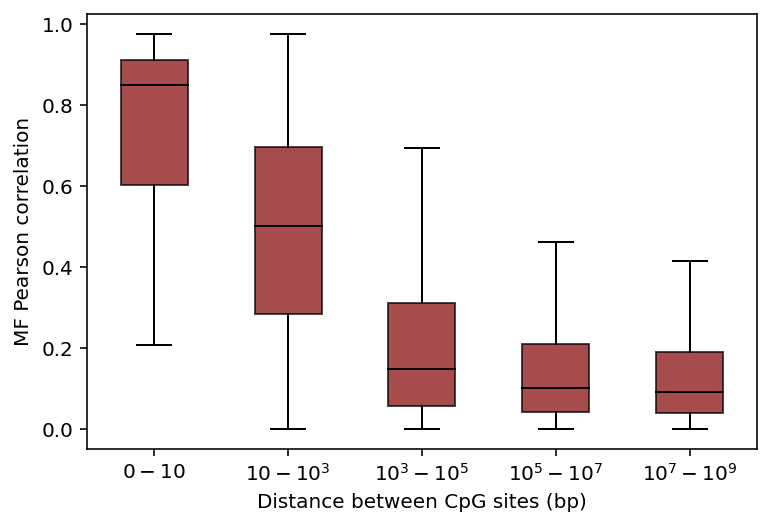

In [160]:
utils.plot_corr_dist_boxplots(other_corr_dist)

In [153]:
spearmanr(np.log(dist_tp['distance']), np.abs(corr_tp['corr']))

SpearmanrResult(correlation=-0.013852809635370368, pvalue=0.0)

### selecting highest correlated CpGs

In [8]:
# get CpGs both measures have
common_cpgs = list(set(chrom_one_distances.columns) & set(chrom_one_corr.columns))
# select 5000 of these CpGs at random
# put both datframes in this order
dist_df = chrom_one_distances.loc[common_cpgs, common_cpgs]
corr_df = chrom_one_corr.loc[common_cpgs, common_cpgs]

In [9]:
# for a given cpg, get counts of distance of top N correlated sites
def get_corr_by_distance(corr_df, dist_df):
    all_corrs = []
    all_dists = []
    for cpg_name in corr_df:
        high_corrs = corr_df[cpg_name].nlargest(11)
        # remove self
        high_corrs = high_corrs.iloc[1:]
        corrs = high_corrs.to_list()
        dists = dist_df.loc[cpg_name, high_corrs.index.to_list()].to_list()
        all_corrs+=corrs
        all_dists+=dists
    
    return pd.DataFrame({'corrs': all_corrs, 'dists':all_dists})

In [10]:
corr_dist_df = get_corr_by_distance(corr_df, dist_df)

In [11]:
corr_dist_df.shape

(265020, 2)

Text(0, 0.5, 'MF Pearson correlation')

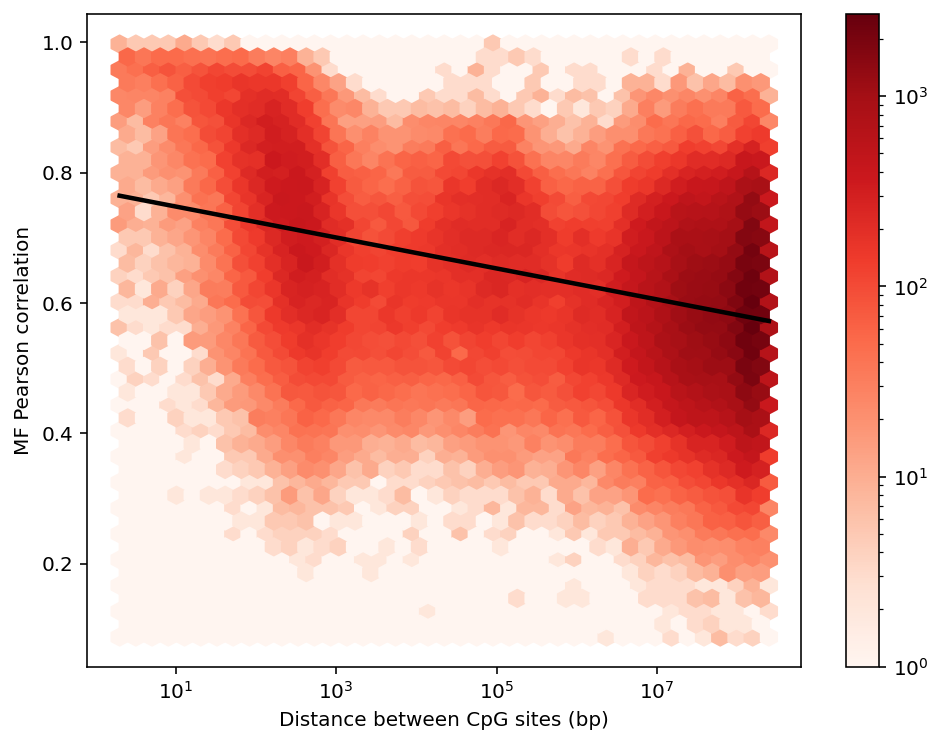

In [18]:
fig, axes = plt.subplots(figsize=(8,6))
p = axes.hexbin(corr_dist_df['dists'], corr_dist_df['corrs'], bins='log', xscale='log', cmap="Reds", gridsize=40)
fig.colorbar(p)
sns.regplot(x=corr_dist_df['dists'], y=corr_dist_df['corrs'], logx=True, ax=axes, scatter=False, color='black')
axes.set_xlabel("Distance between CpG sites (bp)")
axes.set_ylabel("MF Pearson correlation")


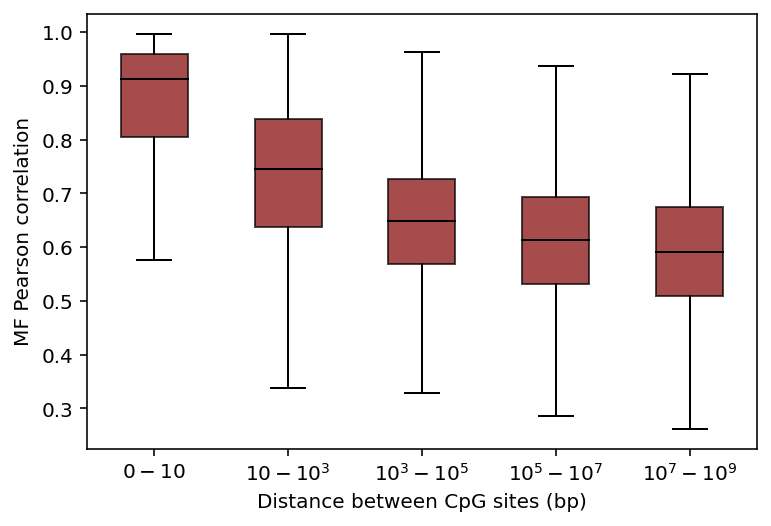

In [21]:
utils.plot_corr_dist_boxplots(corr_dist_df)

In [196]:
spearmanr(np.log10(corr_dist_df['dists']), corr_dist_df['corrs'])

SpearmanrResult(correlation=-0.0991141268984928, pvalue=0.0)

### plot of CpGs average correlation with top site, second to top, ..., least correlation

#### To help choose # linked sites

In [32]:
def get_avg_corr(corr_df, dist_df):
    all_corrs = []
    all_dists = []
    for cpg_name in corr_df:
        high_corrs = np.abs(corr_df[cpg_name]).nlargest(1001)
        # remove self
        high_corrs = high_corrs.iloc[1:]
        corrs = high_corrs.to_list()
        all_corrs.append(corrs)
        # also get distances
        dists = dist_df.loc[high_corrs.index, cpg_name]
        all_dists.append(dists.to_list())
    return pd.DataFrame(all_corrs), pd.DataFrame(all_dists)

In [33]:
top_corrs, top_dists = get_avg_corr(corr_df, dist_df)

In [52]:
corr_means = np.abs(top_corrs).median()
dist_means = top_dists.median() /1000000

Text(0, 0.5, 'Median Distance (Mbp)')

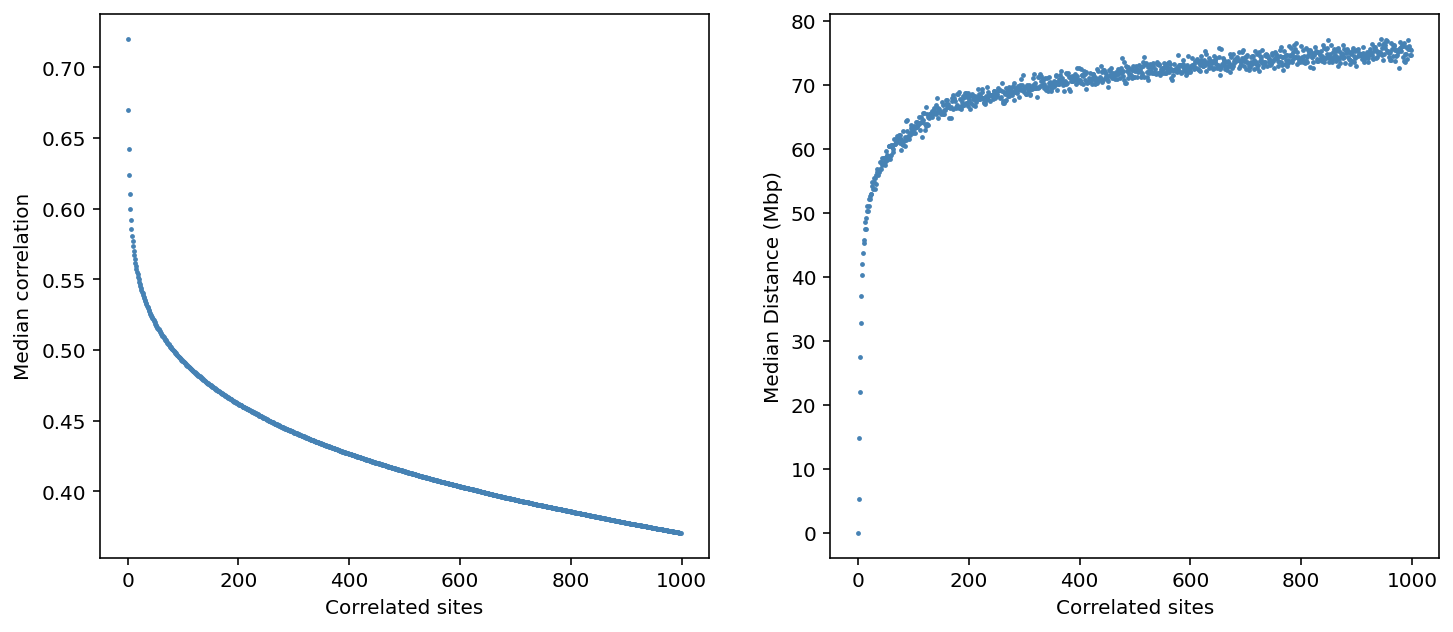

In [59]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].scatter(np.arange(0,1000,1), corr_means.to_list(), s=2, color='steelblue')
axes[0].set_xlabel("Correlated sites")
axes[0].set_ylabel("Median correlation")

axes[1].scatter(np.arange(0,1000,1), dist_means,s =2, color='steelblue')
axes[1].set_xlabel("Correlated sites")
axes[1].set_ylabel("Median Distance (Mbp)")
# all sites on chromosome 1, find the 1000 cpg sites with highest correlation
# plot the average correlation and distance for each of these 1000 sites

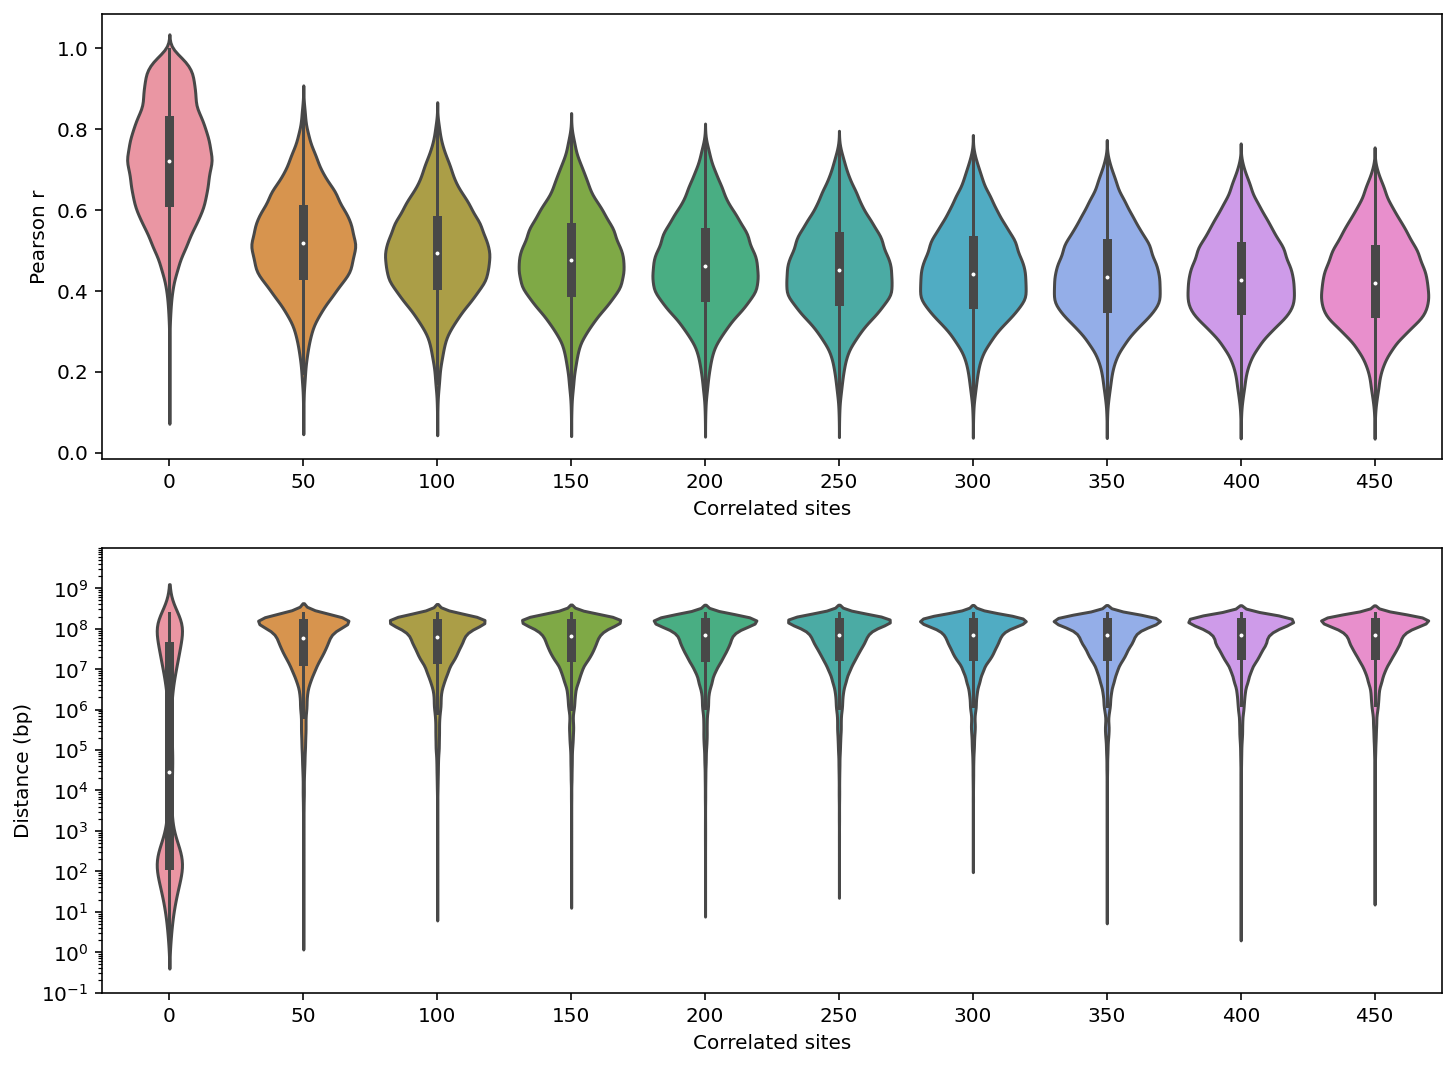

In [86]:
from matplotlib import ticker as mticker

fig, axes = plt.subplots(2,1, figsize=(12,9))
sns.violinplot(data=top_corrs.iloc[:,:500:50], ax=axes[0])
sns.violinplot(data=np.log10(top_dists.iloc[:,:500:50]), ax=axes[1], )
axes[0].set_ylabel("Pearson r")
axes[0].set_xlabel("Correlated sites")

axes[1].set_xlabel("Correlated sites")
axes[1].set_ylabel("Distance (bp)")

zzz= axes[1].yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
ymin, ymax = axes[1].get_ylim()
tick_range = np.arange(np.floor(ymin), ymax)
z= axes[1].yaxis.set_ticks(tick_range)
zz= axes[1].yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)


## Heatmap example of mutational disturbance of methylome

In [ ]:
# first find an example with large disturbance

# iterate across mutations in decreasing order of change in MF, and for each calculate the effect on 100 most linked CpGs (NOT VARYING LINKAGE)

# then choose the on with the largest effect on linked CpGs

In [19]:
# get num_mut_sites sites with largeset MF differences that are on chrom 1 to use as sites in co-methylation analysis
num_mut_sites = 703
most_negative_mut_diffs = ct_mut_in_measured_cpg_w_methyl_age_df[ct_mut_in_measured_cpg_w_methyl_age_df['#id'].isin(chrom_one_corr.columns)].sort_values(by='difference').iloc[:num_mut_sites]

In [21]:
# set linkage type and get the mut_linkage_df based on this type and the 
linkage_type = 'methylation_corr'
if linkage_type == 'methylation_corr':
    mut_linkage_df = chrom_one_corr[most_negative_mut_diffs['#id']]    
elif linkage_type == 'distance':
    mut_linkage_df = chrom_one_distances[most_negative_mut_diffs['#id']] 

In [67]:
# Run co-methylation, takes a while
result_dfs = comethylation.mutation_eff_varying_linkage(mut_linkage_df,
                                linkage_type,
                                ct_mut_in_measured_cpg_w_methyl_age_df,
                                all_methyl_age_df_t,
                                illumina_cpg_locs_df,
                                num_linked_sites = 100,
                                age_bin_size = 10)

1


In [86]:
utils.write_out_result_dfs(out_dir, 'comethyl_all_703_mut_sites_chr1', result_dfs)

In [93]:
# name index to mutated CpGs
result_df = result_dfs[0]
result_df.index = mut_linkage_df.columns
# find the mutation with most negative eff_mean_avg_err
result_df.sort_values(by=['eff_mean_avg_err'])

,p_mean_abs_err,eff_mean_abs_err,linked_mean_abs_err,non_linked_mean_abs_err,p_mean_avg_err,eff_mean_avg_err,linked_mean_avg_err,non_linked_mean_avg_err
cpg_name,,,,,,,,
cg15730879,1.0,0.444326,0.511865,0.067539,0.0,-0.488252,-0.500836,-0.012584
cg15980363,1.0,0.363963,0.432469,0.068506,0.0,-0.423516,-0.420337,0.003178
cg05921170,1.0,0.269230,0.368241,0.099011,0.0,-0.355708,-0.323872,0.031836
cg08709672,1.0,0.277952,0.346412,0.068461,0.0,-0.347996,-0.334426,0.013570
cg08947445,1.0,0.241123,0.359911,0.118788,0.0,-0.347820,-0.350577,-0.002757
...,...,...,...,...,...,...,...,...
cg14848594,1.0,0.371598,0.499488,0.127890,1.0,0.426525,0.497496,0.070971
cg18623672,1.0,0.390760,0.470040,0.079280,1.0,0.456797,0.466588,0.009791
cg02079933,1.0,0.456353,0.540117,0.083763,1.0,0.498291,0.531050,0.032760


In [109]:
# supposing that 'cg21164741' is chosen, show a heatmap of 100 linked sites and 100 least linked sites for the sample with mutation vs 10 others
chosen_site = 'cg15730879'
most_linked = comethylation.select_pos_corr_sites(chosen_site, mut_linkage_df, 100, 1)
least_linked = comethylation.select_pos_corr_sites(chosen_site, mut_linkage_df, 100, 0)
sample_w_mut = ct_mut_in_measured_cpg_w_methyl_age_df[ct_mut_in_measured_cpg_w_methyl_age_df['#id'] == chosen_site]['case_submitter_id'].values[0]

In [121]:
# get 20 random samples 
random_samples = all_methyl_df_t.index[:74].to_list()
assert sample_w_mut not in random_samples

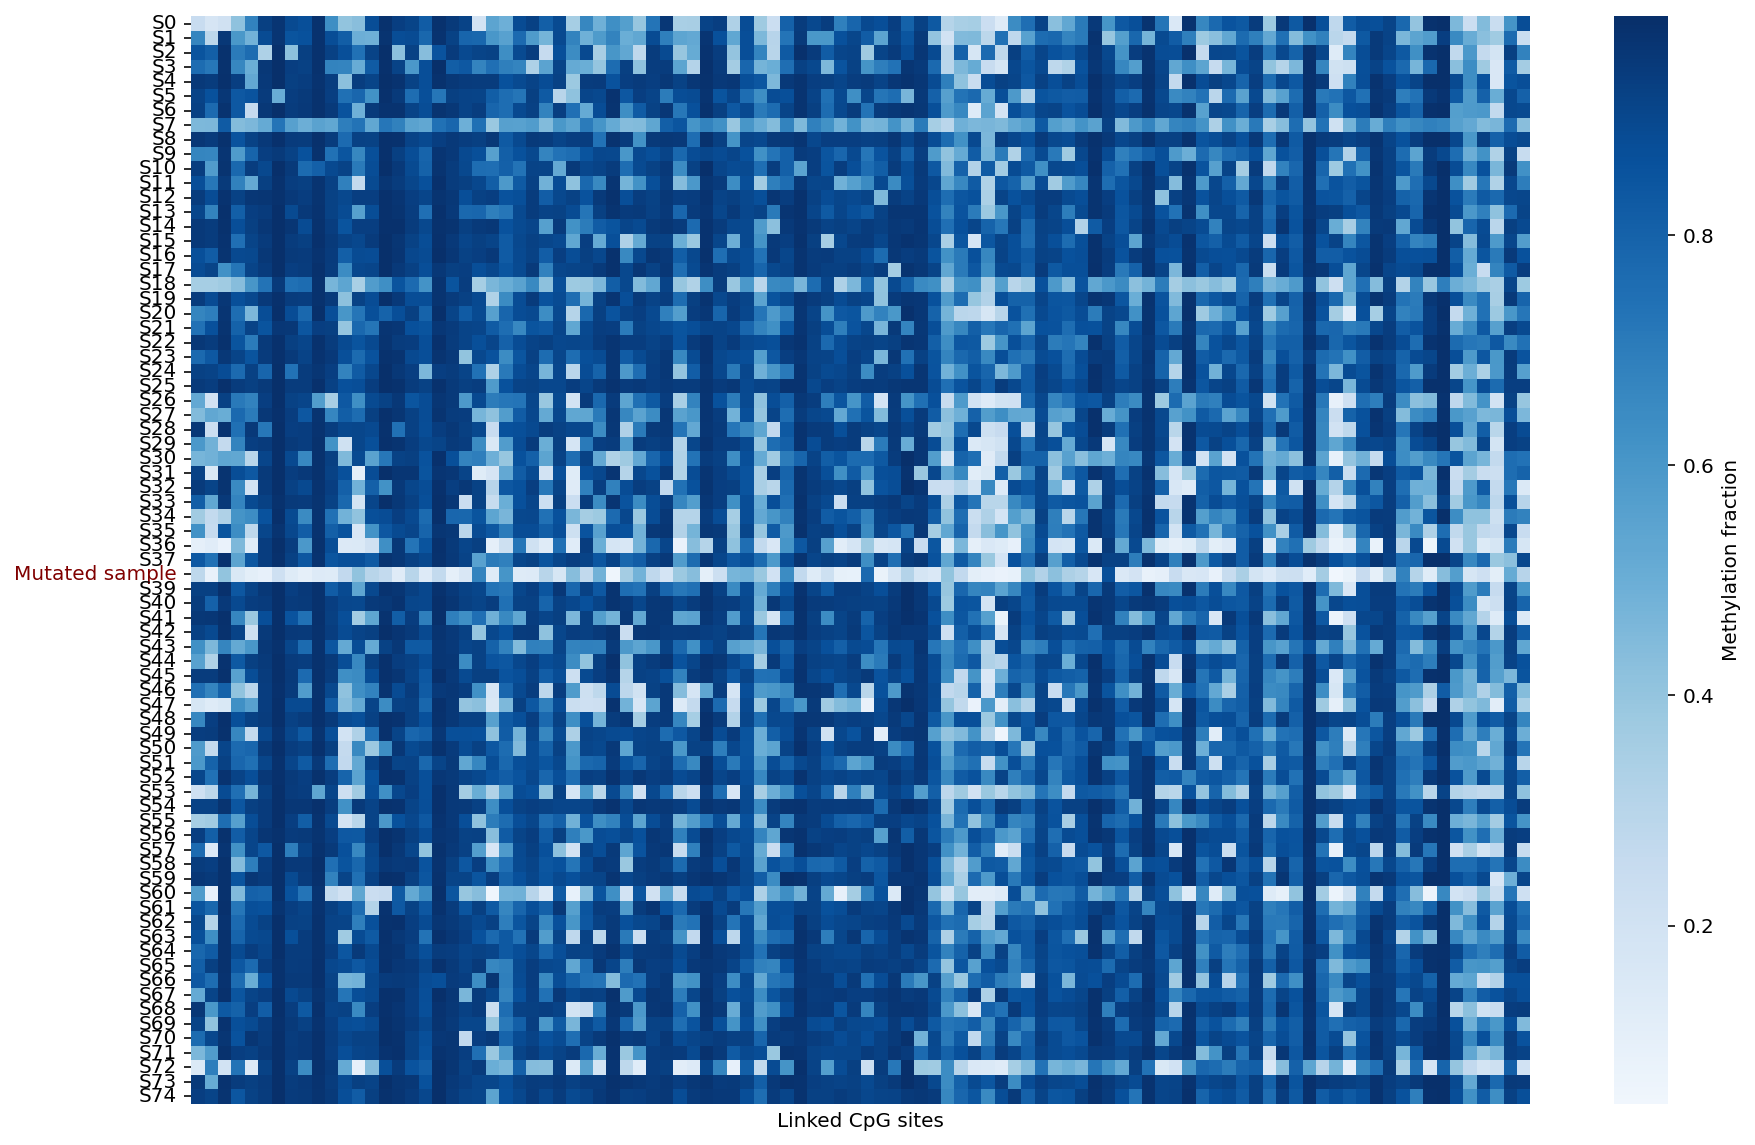

In [159]:
# plot the sample with mut and then 20 random samples across first the mutated site, then 10 linked sites, then 10 unlinked sites
fig = plt.figure(figsize=(15,10))
df = all_methyl_df_t.loc[random_samples[:int(len(random_samples)/2)+1] + [sample_w_mut]+ random_samples[int(len(random_samples)/2)+1:], most_linked]
ax = sns.heatmap(df, annot=False, center=0.5, xticklabels=False, cmap="Blues",
                 yticklabels=["Sample {}".format(i) if i!= int(len(random_samples)/2)+1 else "Mutated sample" for i in range(len(random_samples)+1)], cbar_kws={'label': 'Methylation fraction'})
plt.yticks(rotation=0) 
ax.set_xlabel("Linked CpG sites")
for i, tick_label in enumerate(ax.axes.get_yticklabels()):
    if i == 38:
        tick_label.set_color("Maroon")

## Association between VAF, MF change, start methylation with eff_m_avg_err

In [9]:
# read in the result df from above which contains co-methylation with linked being correltion results for all 703 mutated sites on chr1
result_dfs = utils.read_in_result_dfs(os.path.join(dependency_f_dir, 'comethyl_all_703_mut_sites_chr1'))

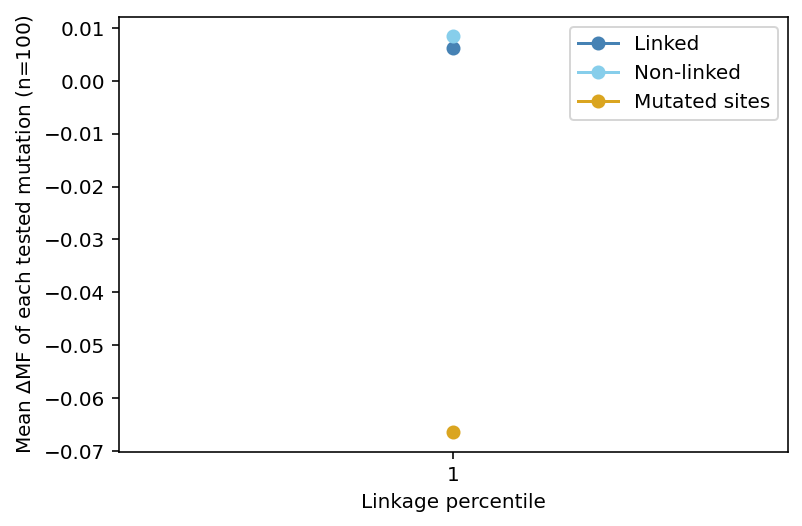

In [22]:
comethylation.plot_eff_line(result_dfs, ct_mut_in_measured_cpg_w_methyl_age_df, mut_linkage_df, sig_only=False)

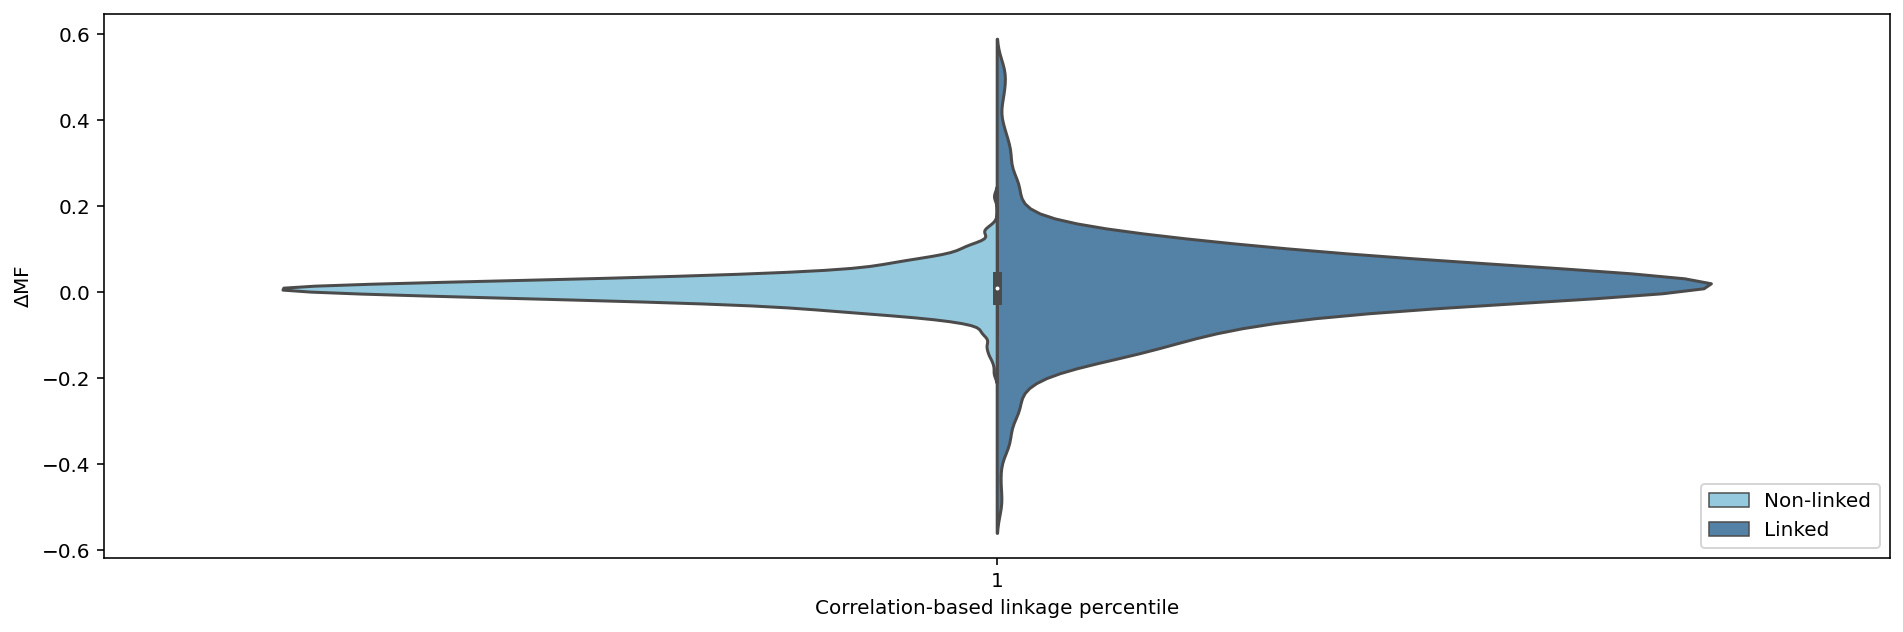

In [23]:
comethylation.plot_eff_violin(result_dfs)